# Basin-Hopping algorithm for the optimization of lens curvatures through ray tracing

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.optimize import basinhopping
from scipy.optimize import fsolve

%matplotlib notebook

## Ray Tracer
The ray tracers works by tracing rays through the optical system using translation and refraction steps. At a translation step the intersection between the ray and a spherical lens surface is calculated. The refraction at the sphere's surface is calculated through Snell's law.

### Translation
The vector form of a sphere is given by the set of points $\vec{\rho}$ which satisfies: 

$$\|\vec{\rho} - \vec{a}\|^2 = R^2$$

where $\vec{a}$ is the center position vector of the sphere, with its radius $R$. The sign of $R$ indicates its orientation, where a positive sign indicates convex to the left.

The light ray is described by a straight line:

$$\vec{\rho} = \vec{p_0} + t \hat{\varphi}, \quad t \in \mathbb{R}$$

Where $\hat{\varphi}$ is the direction unit vector and $\vec{p_0}$ is the position vector of the ray.

The intersection point is found by substituting the equation of the line into the equation of the sphere:

$$\|\vec{p_0} + t \hat{\varphi} - \vec{a}\|^2 = R^2$$

Given that the ray intersects the sphere, solving for $t$ gives two solutions:

$$t_{1,2} = - \hat{\varphi} \cdot (\vec{p_0} - \vec{a}) \pm \sqrt{[\hat{\varphi} \cdot (\vec{p_0} - \vec{a})]^2 - \| \vec{p_0} - \vec{a} \| ^2 + R^2}$$

The correct $t_{1,2}$ is chosen from the two options (depending on a positive or negative $R$) and then used to calculate the intersection point by $\vec{p_0} + t_{1,2} \hat{\varphi}$.


### Refraction
The vector form of Snell's law is given by:

$$n_i (\hat{\varphi}_i \times \hat{n}) = n_t (\hat{\varphi}_t \times \hat{n})$$

Where $n_i, n_t$ are the indices of refraction of the incident and transmitted medium, respectively. $\hat{\varphi}_i, \hat{\varphi}_t$  are the direction unit vectors of the incident and transmitted beam, respectively. $\hat{n}$ is the normal vector of the sphere's surface pointing radially outwards.

This equation can be rewritten to $(\hat{\varphi}_i - \frac{n_t}{n_i} \hat{\varphi}_t) \times \hat{n} = 0$, which indicates that:

$$ \hat{\varphi}_i - \frac{n_t}{n_i} \hat{\varphi}_t = \lambda \hat{n} $$

Taking the inner product with $\hat{n}$ on both sides yields: $\lambda = \hat{\varphi}_i \cdot \hat{n} - \frac{n_t}{n_i} \hat{\varphi}_t \cdot \hat{n}$.  
This equation can be solved by using the 2D equation of Snell's law ($n_i \sin \theta_i = n_t \sin \theta_2$) and identifying that $-\hat{\varphi}_i \cdot \hat{n} =\cos\theta_i$ and $-\hat{\varphi}_t \cdot \hat{n} = \cos\theta_t$, such that Snell's law can be rewritten to 

$$\cos \theta_t = \sqrt{1 -  (\frac{ni}{nt})^2 (1-\cos^2 \theta_i)} \quad \rightarrow \quad
-\hat{\varphi}_t \cdot \hat{n} = \sqrt{1 -  (\frac{ni}{nt})^2 (1-[\hat{\varphi}_i \cdot \hat{n}]^2)}$$

such that $\lambda = \hat{\varphi}_i \cdot \hat{n} + \frac{n_t}{n_i} \sqrt{1 -  \left(\frac{n_i}{n_t}\right)^2 \left(1-[\hat{\varphi}_i \cdot \hat{n}]^2\right)}$. 

Now the beam's angle after refraction can be calculated to be:

$$\hat{\varphi}_t = \frac{n_i}{n_t} \hat{\varphi}_i - \left( \frac{n_i}{n_t} \hat{\varphi}_i \cdot \hat{n} + \sqrt{1 -  \left(\frac{n_i}{n_t}\right)^2 \left(1-[\hat{\varphi}_i \cdot \hat{n}]^2\right)} \right) \hat{n}$$

## Optimization of lens system
The optical system's parameters (radius of curvature and distance between lens surfaces) are optimized according to the basin-hopping algorithm. This algorithm minimizes the fitness function of the lens system for different wavelengths and incident angles. The fitness function $F$ is defined as <sup>[1]</sup>:

$$ F = \sqrt{\frac{2}{3N(3N-1)} \sum_{i < j} d_{i,j}^2} $$

Where $N$ is the number of rays traced through the system in one bundle. $d_{i,j}$ is the distance between spots $i$ and $j$ in the focal plane.

After optimization the spot diagrams can be shown of the lens system. 
The ray tracing software does not include the ray properties of light. A circle is added to the spot diagram corresponding to the diffraction limit for reference.
The diffraction limit is given by:

$$ d = 2.44 \frac{\lambda f}{D} $$

Where $D$ is the diameter of the front lens.

<sup>[1]</sup> Optical design with the aid of a genetic algorithm, *Thijssen*, BioSystems, 1996

In [2]:
class ray_tracer():
    '''
    Trace rays through the optical system. Input an incoming ray, 
    outputs the final position on a flat plane in the paraxial focal point.
    The first lens is always positioned at (0, 0, 0). 
    
    d are the distances to the next lens surface on the z-axis starting from (0, 0, 0).
    R are the radii of curvature of the spherical lenses.
    n are the indices of refraction from the first lens to the last (including air layers in-between).
    wavelength is the lights wavelength in um.
    '''
    def __init__(self, **kwargs):
        # Lens material: N-FK51 (first) and KzFSN4 (second) glass.
        self.nDict = {
            '0.48613': [1.4906, 1, 1.6231], # 0.48613 um
            '0.54607': [1.4879, 1, 1.6167], # 0.54607 um
            '0.65627': [1.4848, 1, 1.6092], # 0.65627 um
            }
        
        if 'R' and 'd' in kwargs.keys():
            print('setting lens parameters with R and d')
            self.SetParameters(kwargs['R'], kwargs['d'])
    
    
    def _GetRayParameters(self):
        '''Get the wavelengths and starting angles of the rays'''
        wavelength = sorted([float(key) for key in self.nDict.keys()])
        phi0 = [np.array([0, np.sin(angle), np.cos(angle)]) for angle in np.linspace(0, 0.03, 5)]
        return wavelength, phi0
    
    
    def SetParameters(self, R, d):
        '''(re)initializing radius of curvature of the lens system'''
        self.d = np.concatenate([[0], np.cumsum(np.append(d, 2000))])
        self.R = np.append(R, 1e10)
        self.a = [np.array([0, 0, z]) for z in (self.d + self.R)]
    
    
    def FitnessSystem(self, Rd):
        '''
        Get the fitness of the lens system for the given R and d.
        Rd is an combined list of the radius of curvatures appended with the distances between the lenses.
        Outputs the fitness of the lens system for three wavelengths and 5 angles.
        '''
        wavelength, phi0 = self._GetRayParameters()
        
        R = Rd[:int(np.ceil(len(Rd)/2))]
        d = Rd[int(np.ceil(len(Rd)/2)):]
        self.SetParameters(R, d)
        
        fitness = []
        
        for ii in range(len(wavelength)):
            for jj in range(len(phi0)):
                fitness.append(self.FitnessLens(wavelength[ii], phi0[jj]))
        
        return sum(fitness)
    
    
    def FitnessLens(self, wavelength, phi0):
        '''Fitness function when tracing an array of rays through the optical system.'''
        pFocus = self.TraceArray(wavelength, phi0)
        N = len(pFocus) # number of rays
        D = []
        
        # iterate over the number of ray pairs
        for jj in range(N):
            for ii in range(jj):
                    D.append(np.sqrt(2/(3*N*(3*N-1)) * np.linalg.norm(pFocus[ii]-pFocus[jj])))
        
        return sum(D)
    
    
    def TraceArray(self, wavelength, phi0 = np.array([0, 0, 1]), Rtot=50, spacingFactor=6, plot=False):
        '''Trace an array of rays through the optical system.'''
        self.n = np.concatenate([[1], self.nDict[str(wavelength)], [1]])
        
        p0Array = self._initialArray(Rtot, spacingFactor) # create the initial starting positions of the rays
        
        pRays = np.zeros((len(p0Array), len(self.R)+1, 3)) # create position array
        
        for ii in range(len(p0Array)):
            pRays[ii] = self.TraceRay(p0Array[ii], phi0) # trace the rays through the optical system
        
        if plot:
            self.plotRays(pRays)
        
        return pRays[:, -1] # return positions of rays in focal plane
    
    
    def _initialArray(self, Rtot, spacingFactor):
        '''
        Rtot is the total radius of the beams.
        spacingFactor determines the spacing between the rays, it defined as: spacing = Rtot/spacingFactor 
        '''
        spacing = Rtot/spacingFactor # distance between rays
        r = np.arange(0, Rtot, spacing)
        x, y = [0], [0]
        
        for ii in range(len(r)):
            angleSpacing = np.linspace(0, 2*np.pi, num=2*np.pi*r[ii]/spacing, endpoint=False)
            xi, yi, _ = self._sphericalToCartesian(r[ii], np.pi/2, angleSpacing)
            x.extend(xi)
            y.extend(yi)
        
        p0Array = np.stack((np.array(x), np.array(y), np.zeros(len(x))), axis=1)
        
        self.dLens = np.sqrt(p0Array[-1, 0]**2 + p0Array[-1, 1]**2)
        
        return p0Array
    
    
    def TraceRay(self, p0, phi0): # add n as input
        '''
        Trace a ray through the optical system.
        p0 is the position vector of the initial beam.
        Output is the final position of the beam on the image plane.
        '''
        p = np.zeros((len(self.R) + 1, 3))
        p[0] = p0
        self.phi = phi0
        
        for ii in range(len(self.R)-1):
            p[ii+1] = self.__Translation(p[ii], self.R[ii], self.a[ii])
            self.__Refraction(p[ii+1], self.R[ii], self.a[ii], self.n[ii], self.n[ii+1])
        
        p[-1] = self.__Translation(p[-2], self.R[-1], self.a[-1])
        
        return p
    
    
    def __Translation(self, p, R, a):
        '''
        Translate a ray through space from its initial position to the intersection point between the ray and the sphere.
        p is initial the position vector.
        R is the radius of curvature of the lens.
        a is the center position vector of the spherical lens.
        Returns the new position at the intersection point of the ray with the lens.
        '''
        D = np.dot(self.phi, p-a)**2 - np.dot(p-a, p-a) + R**2
        
        if D >= 0:
            if R > 0:
                t = -np.dot(self.phi, p-a) - np.sqrt(D)
            else:
                t = -np.dot(self.phi, p-a) + np.sqrt(D)
        else:
            raise ValueError('Ray tracing failure: ray misses sphere.')
        
        return p + t*self.phi
    
    
    def __Refraction(self, p, R, a, ni, nt):
        '''
        Adjusts the direction of the light beam due to refraction at an interface according to Snell's law.
        p is the position vector at the lens' surface.
        R is the radius of curvature of the spherical lens.
        a is the center position vector of the spherical lens.
        ni is the index of refraction of the incoming medium.
        nt is the index of refraction of the transmitted medium.
        '''
        if R > 0:
            n = (p - a)/np.linalg.norm(p - a) # normal vector of lens surface
        else:
            n = -(p - a)/np.linalg.norm(p - a)
        
        self.phi = ni/nt * self.phi - (ni/nt * np.dot(self.phi, n) + np.sqrt(1 - (ni/nt)**2 * (1 - np.dot(self.phi, n)**2)))*n
    
    
    def plotRays(self, pRays):
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        
        for ii in range(len(pRays)):
            ax.plot(pRays[ii, :, 0], pRays[ii, :, 1], pRays[ii, :, 2])
            
        plt.show()
    
    
    def spotDiagrams(self, Rd):
        '''Plot the spot diagrams of the rays with different wavelength and incident angle.'''
        wavelength, phi0 = self._GetRayParameters()
        
        R = Rd[:int(np.ceil(len(Rd)/2))]
        d = Rd[int(np.ceil(len(Rd)/2)):]
        self.SetParameters(R, d)
        
        fig, ax = plt.subplots(len(phi0), len(wavelength), figsize=(9, 9), sharex='all', sharey='row')
        
        for ii in range(len(wavelength)):
            for jj in range(len(phi0)):
                pFocus = self.TraceArray(wavelength[ii], phi0[jj])
                pFocus[:, 1] -= np.mean(pFocus[:, 1])
                ax[jj, ii].plot(pFocus[:, 0], pFocus[:, 1], 'o', ms=3)
                
                d = 2.44*wavelength[ii]*1e-3*(self.d[-1]-self.d[-2])/self.dLens
                x, y, _ = self._sphericalToCartesian(d, np.pi/2, np.linspace(0, 2*np.pi, 50))
                ax[jj, ii].plot(x, y, c='k')
                
                ax[jj, ii].set_xticks([])
                ax[jj, ii].set_yticks([])
                ax[jj, ii].set_ylim(min(pFocus[:, 1]), max(pFocus[:, 1]))
                ax[jj, ii].set_aspect('equal', adjustable='datalim')
                
            ax[0, ii].set_title(r'$\lambda$={} nm'.format(wavelength[ii]*1e3), size=16)
        
        for jj in range(len(phi0)):
            plt.gcf().text(0.88, 0.86-.95*jj/len(phi0), r'$\theta_i$={0:.4f}'.format(phi0[jj][1]), fontsize=14)
        
        plt.tight_layout()
        plt.subplots_adjust(right=0.85)
        plt.show()
    
    
    def _paraxialRayTrace(self, d, n, R):
        '''
        Calculate the back focal length according to paraxial ray tracing.
        d are the distances between the lens surfaces.
        n are the indices of refraction of the materials, including the initial and final medium (outside the lens system).
        R are the radii of curvature of the spherical lenses.
        '''
        A = np.identity(2)
        
        for ii in range(len(d)):
            refraction = np.matrix([[1, -(n[ii+1]-n[ii])/R[ii]], [0, 1]])
            A = refraction * A
            transfer = np.matrix([[1, 0], [d[ii]/n[ii+1], 1]])
            A = transfer * A
        
        ii = len(d)
        refraction = np.matrix([[1, -(n[ii+1]-n[ii])/R[ii]], [0, 1]])
        A = refraction * A
        
        return -1/A[0, 1] - n[-1]*(A[1, 1] - 1)/A[0, 1] # return back focal length of lens system
    
    
    def _sphericalToCartesian(self, r, theta, phi):
        return(r*np.sin(theta)*np.cos(phi), r*np.sin(theta)*np.sin(phi), r*np.cos(theta))

## Results

                     x: array([ 1167.27084466, -1002.3546901 ,  -773.78011531, -1956.72949889,
         213.97718316,    51.94389784,   156.04496179])
                   fun: 62.09716612418409
                  njev: 93
                  nfev: 885
                   nit: 3
 minimization_failures: 4
               message: ['requested number of basinhopping iterations completed successfully']


<IPython.core.display.Javascript object>


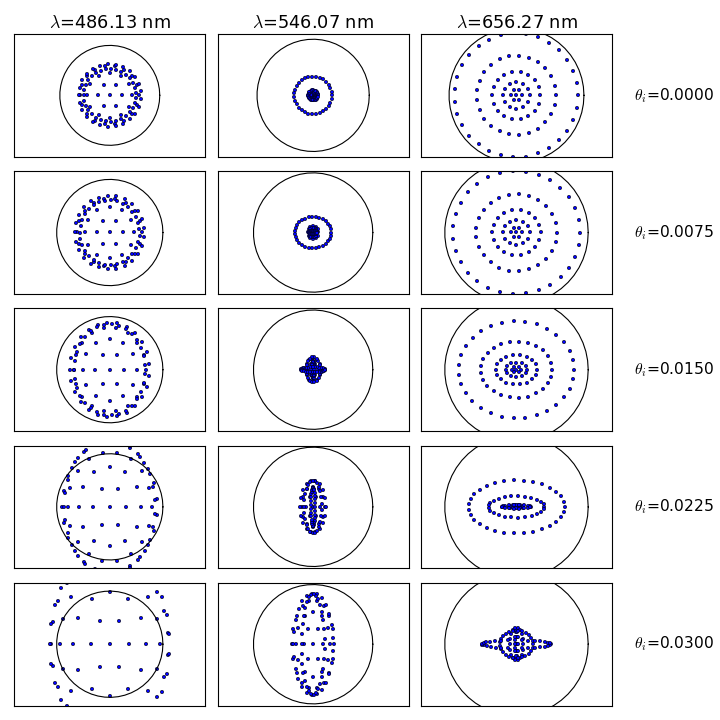

<IPython.core.display.Javascript object>


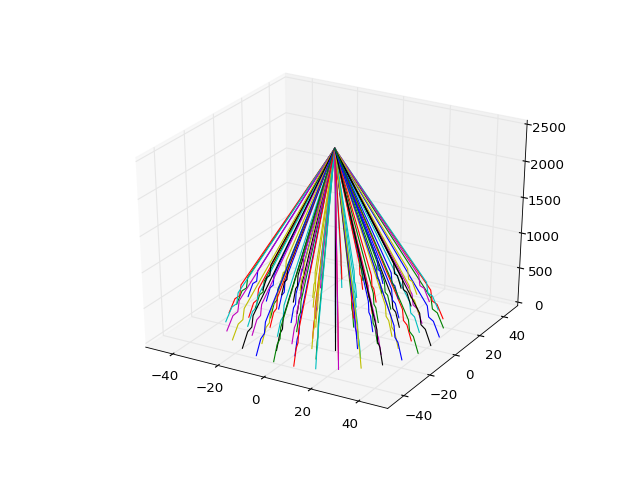

In [3]:
Rays = ray_tracer()
ret = basinhopping(Rays.FitnessSystem, x0=[1000, -1000, -1000, -2000, 100, 100, 100], niter=3, stepsize=50, T=30)

print(ret)
Rays.spotDiagrams(ret.x)
_ = Rays.TraceArray(0.54607, plot=True)